In [1]:
import load_data, rotplot
import math
import matplotlib.pyplot as plt
import autograd.numpy as np
import transforms3d
import optimization

In [2]:
[camera,imu,Vicd] = load_data.load(fname="../../trainset",dataset="1")

Data import took: 0.005578041076660156 sec.



In [3]:
rots = []
for i in range(Vicd['rots'].shape[2]):
    rots.append(list(transforms3d.euler.mat2euler(Vicd['rots'][:,:,i])))

rots = np.array(rots)

In [4]:
sc_ft_ang=3300/1023*(math.pi)/180/3.33
sc_ft_acc=3300/1023/300

Wz = imu['vals'][3]
Wx = imu['vals'][4]
Wy = imu['vals'][5]
Ang_Veloc = np.array([Wx*sc_ft_ang,Wy*sc_ft_ang,Wz*sc_ft_ang])

Ax = imu['vals'][0].astype(np.float32)*sc_ft_acc
Ay = imu['vals'][1].astype(np.float32)*sc_ft_acc
Az = imu['vals'][2].astype(np.float32)*sc_ft_acc
Ang_Acc = np.array([-Ax,-Ay,Az],dtype=np.float32)

time = imu['ts'][0]

tau = np.zeros((len(time)-1,1))
for i,t in enumerate(time,start=0):
    if i == 0:
        continue
    else:
        tau[i-1] = t - time[i-1]
bias_ang_x=np.average(Ang_Veloc[0,0:100])
bias_ang_y=np.average(Ang_Veloc[1,0:100])
bias_ang_z=np.average(Ang_Veloc[2,0:100])
bias_acc_x=np.average(Ang_Acc[0,0:100])
bias_acc_y=np.average(Ang_Acc[1,0:100])
bias_acc_z=np.average(Ang_Acc[2,0:100])
Ang_Veloc[0] = Ang_Veloc[0] - bias_ang_x
Ang_Veloc[1] = Ang_Veloc[1] - bias_ang_y
Ang_Veloc[2] = Ang_Veloc[2] - bias_ang_z
Ang_Acc[0] = Ang_Acc[0] - bias_acc_x
Ang_Acc[1] = Ang_Acc[1] - bias_acc_y
Ang_Acc[2] = Ang_Acc[2] - bias_acc_z + 1

In [5]:
import quarternions

quarternions_T = quarternions.predict_next_quarternion(tau,Ang_Veloc)

In [6]:
quarts = np.array(quarternions_T)

In [7]:
print(quarts.shape)
print(tau[:,0].shape)
print(Ang_Veloc.T.shape)
print(Ang_Acc.T.shape)

(5645, 4)
(5644,)
(5645, 3)
(5645, 3)


In [8]:
optimized_qts = optimization.optimize(quarts,Ang_Acc.T,tau[:,0],Ang_Veloc.T)

Loss at iteration 1: 106113.09
Loss at iteration 2: 100180.88
Loss at iteration 3: 96707.09
Loss at iteration 4: 94471.74
Loss at iteration 5: 93010.36
Loss at iteration 6: 92074.79
Loss at iteration 7: 91495.46
Loss at iteration 8: 91146.52
Loss at iteration 9: 90938.58
Loss at iteration 10: 90813.36
Loss at iteration 11: 90735.60
Loss at iteration 12: 90685.41
Loss at iteration 13: 90651.46
Loss at iteration 14: 90627.52
Loss at iteration 15: 90610.05
Loss at iteration 16: 90596.74
Loss at iteration 17: 90586.61
Loss at iteration 18: 90578.59
Loss at iteration 19: 90572.20
Loss at iteration 20: 90567.19


In [18]:
np.save("../numpy files/data_set_" + "1" + "_optimized_quarternions",optimized_qts)

In [13]:
euler_angles = list(map(lambda quart: transforms3d.euler.quat2euler(quart),quarternions_T))
roll = list(map(lambda angles: angles[0],euler_angles))
pitch = list(map(lambda angles: angles[1],euler_angles))
yaw = list(map(lambda angles: angles[2],euler_angles))

In [14]:
opt_euler_angles = list(map(lambda quart: transforms3d.euler.quat2euler(quart),optimized_qts))
opt_roll = list(map(lambda angles: angles[0],opt_euler_angles))
opt_pitch = list(map(lambda angles: angles[1],opt_euler_angles))
opt_yaw = list(map(lambda angles: angles[2],opt_euler_angles))

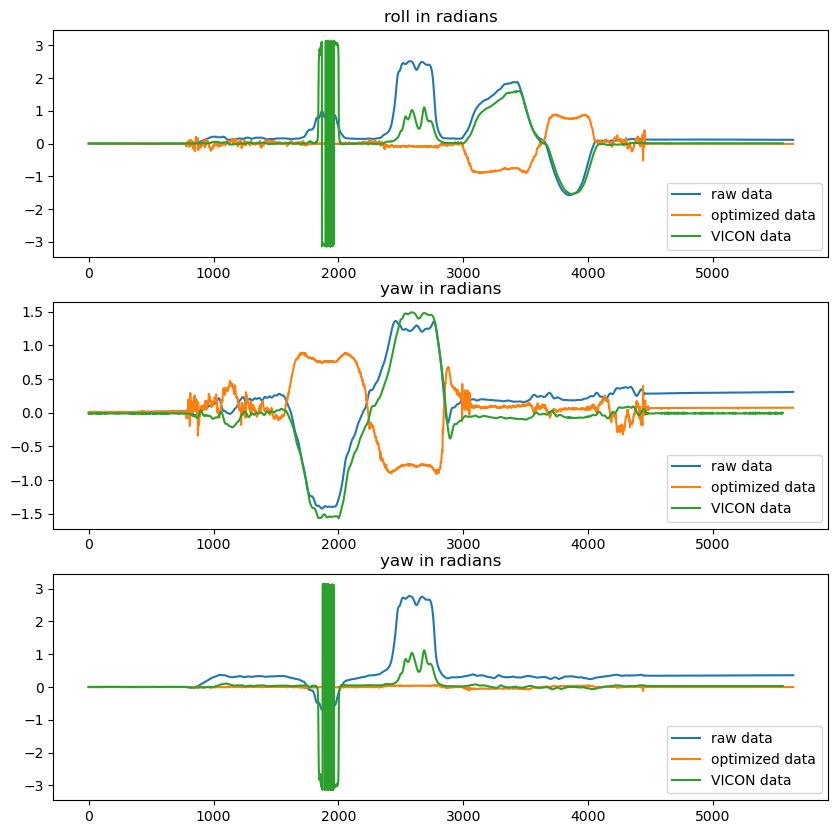

In [15]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
ax[0].plot(roll)
ax[0].set_title("roll in radians")
ax[0].plot(opt_roll)
ax[0].plot(rots[:,0])
ax[1].plot(pitch)
ax[1].set_title("yaw in radians")
ax[1].plot(opt_pitch)
ax[1].plot(rots[:,1])
ax[2].plot(yaw)
ax[2].plot(opt_yaw)
ax[2].set_title("yaw in radians")
ax[2].plot(rots[:,2])
ax[0].legend(['raw data','optimized data','VICON data'],loc='lower right')
ax[1].legend(['raw data','optimized data','VICON data'],loc='lower right')
ax[2].legend(['raw data','optimized data','VICON data'],loc='lower right')

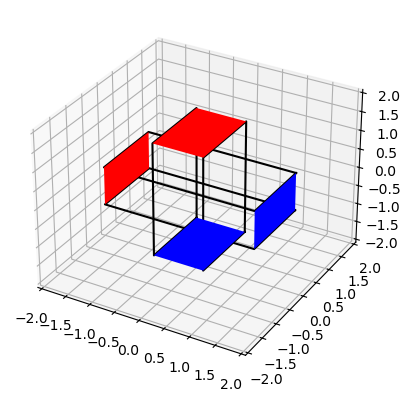

In [12]:
rotplot.example()